In [1]:
import os
import torch
import numpy

import torch.utils.data as data_utils
import matplotlib.pyplot as plt

from PIL import Image
from pathlib import Path
from tqdm import tqdm
from torchvision import transforms
from collections import defaultdict

In [2]:
# !pip install facenet_pytorch

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
images = Path('data/new-make-crop/')

In [4]:
from facenet_pytorch import InceptionResnetV1

# Create an inception resnet (in eval mode):
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

In [5]:
def to_tensor(img, png=False):
    tensor = transforms.ToTensor()(img).to(device)
    # needed in case of image is in PNG format
    return tensor[:3]

In [6]:
class ImageDataset(data_utils.DataLoader):
    def __init__(self, root):
        self.root = root
        self.imgs = os.listdir(root)
        
    def __getitem__(self, index):
        path  = os.path.join(self.root, self.imgs[index])
        image = Image.open(path)
        return to_tensor(image)
    
    def __len__(self):
        return len(self.imgs)

In [7]:
dataset = ImageDataset(images)
loader  = data_utils.DataLoader(dataset, batch_size=1, shuffle=False)

In [8]:
embeddings = []

for image_batch in tqdm(loader, desc='processing batch'):
    image_batch = image_batch.to(device)
    embed_batch = resnet(image_batch)
    embeddings.append(embed_batch.detach().cpu())

processing batch: 100%|██████████| 1520/1520 [00:54<00:00, 27.89it/s]


In [9]:
embeddings = torch.cat(embeddings)

In [10]:
n    = len(embeddings)
diff = [[0 for _ in range(n)] for _ in range(n)]

for i in tqdm(range(n - 1)):
    for j in range(i + 1, n):
        x = embeddings[i]
        y = embeddings[j]
        mse = torch.sum((x - y) ** 2).item()
        diff[i][j] = mse
        diff[j][i] = mse

100%|██████████| 1519/1519 [00:15<00:00, 97.17it/s] 


In [11]:
diff = numpy.array(diff)

In [12]:
def get_similars(matrix, threshold):
    return numpy.argwhere((diff > 0) & (diff < threshold))

In [13]:
similars = get_similars(diff, 0.02)

In [14]:
graph = defaultdict(set)
pred  = {}
used  = set()

In [15]:
for (x, y) in similars:
    w = min(x, y)
    v = max(x, y)
    if w not in used and v not in used:
        graph[w] = {w, v}
        pred[w]  = w
        pred[v]  = v
        used.add(w)
        used.add(v)
    if w in used:
        graph[pred[w]].add(v)
        used.add(v)
        pred[v] = pred[w]
    elif v in used:
        graph[pred[v]].add(w)
        used.add(w)
        pred[w] = pred[v]

In [16]:
graph

defaultdict(set,
            {13: {13, 1202},
             30: {30, 704},
             47: {47, 166},
             74: {74, 248},
             78: {78, 554},
             83: {83, 476},
             90: {90, 1421},
             97: {97, 758},
             105: {105, 1270, 1488},
             112: {112, 420},
             115: {115, 460},
             162: {162, 1251, 1369},
             172: {172, 660},
             173: {173, 678},
             182: {182, 524},
             186: {186, 792},
             192: {192, 706},
             240: {240, 280},
             264: {264, 1517},
             272: {272, 656},
             274: {274, 619, 1008, 1212},
             298: {298, 754, 1368},
             336: {336, 1379},
             360: {360, 506, 812},
             375: {375, 1092, 1235},
             409: {409, 475},
             467: {467, 667},
             485: {485, 571},
             490: {490, 594},
             528: {528, 1204},
             579: {579, 1484},
             634: {

/home/user/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


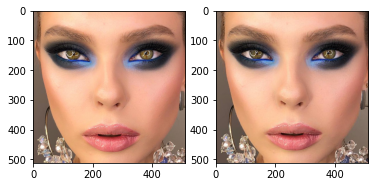

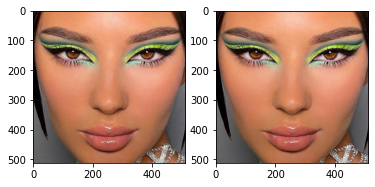

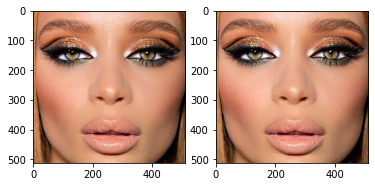

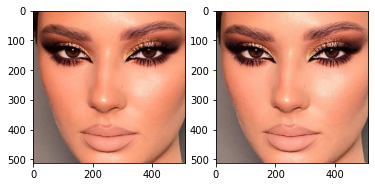

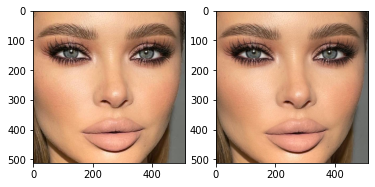

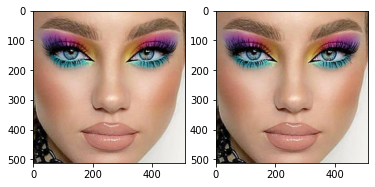

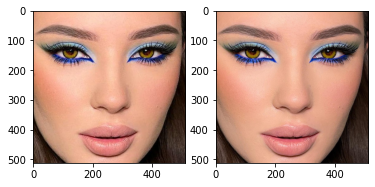

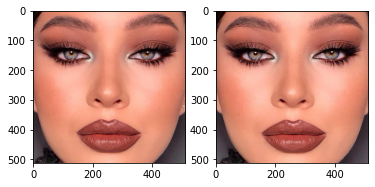

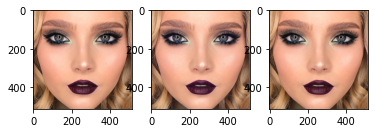

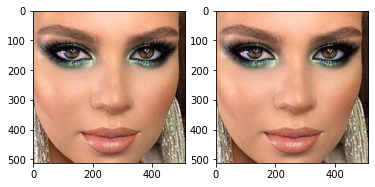

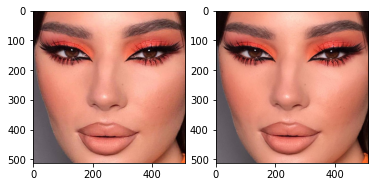

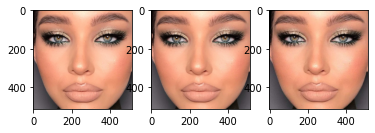

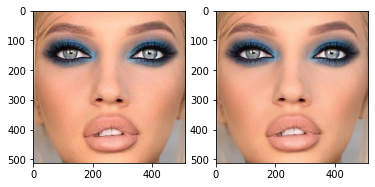

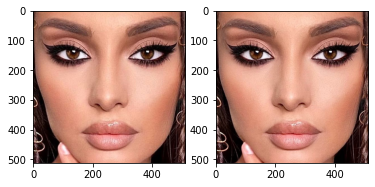

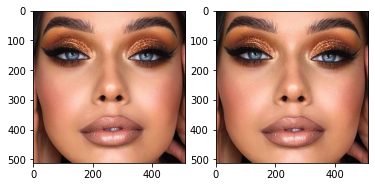

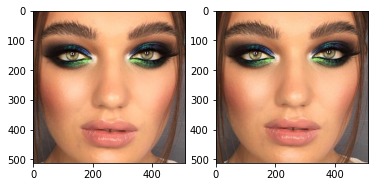

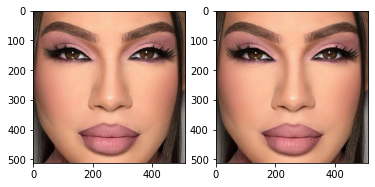

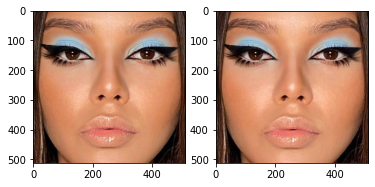

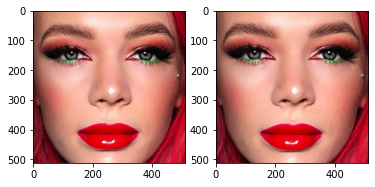

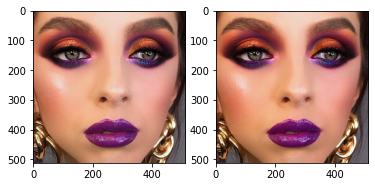

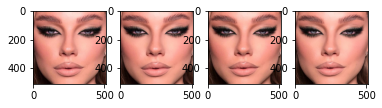

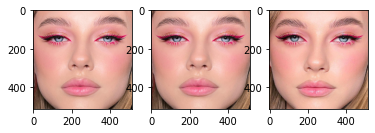

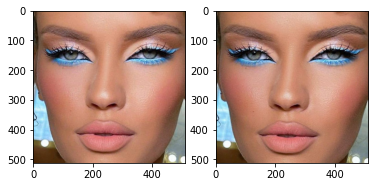

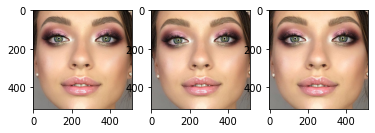

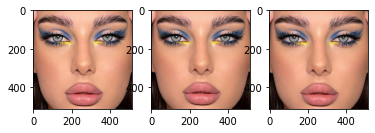

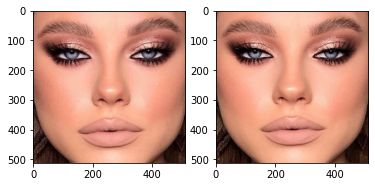

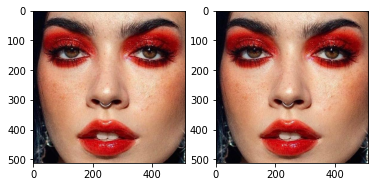

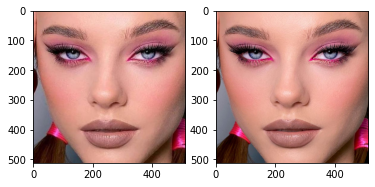

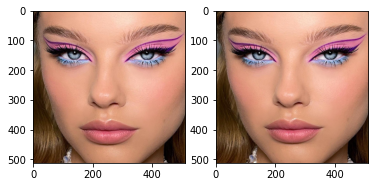

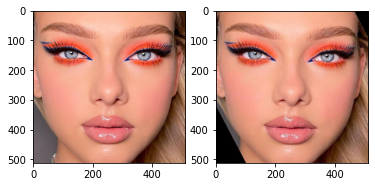

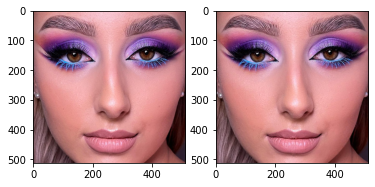

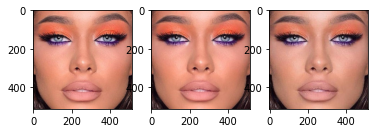

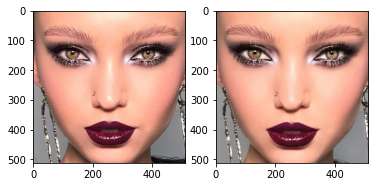

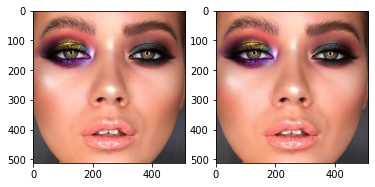

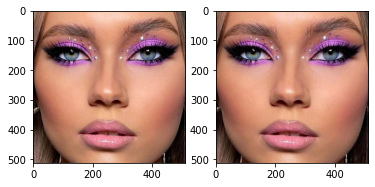

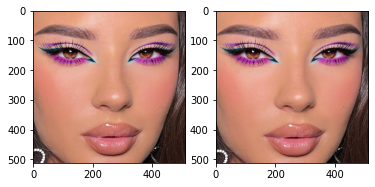

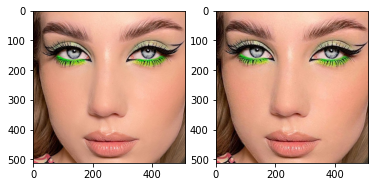

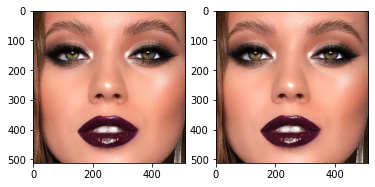

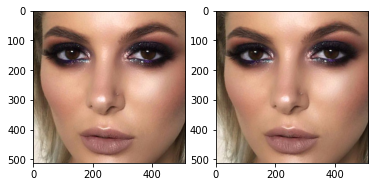

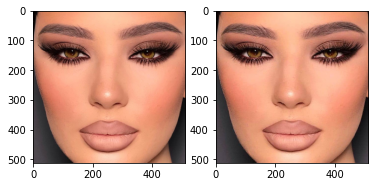

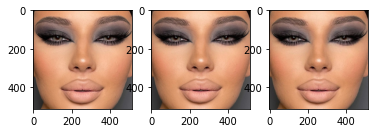

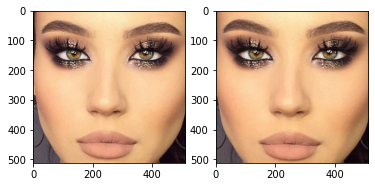

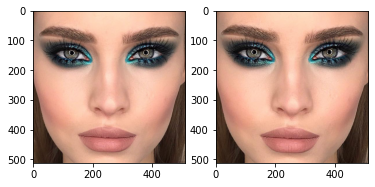

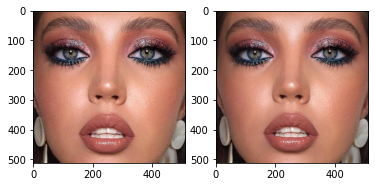

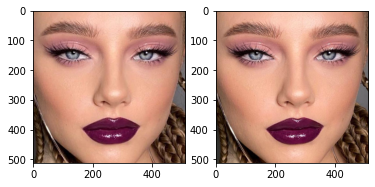

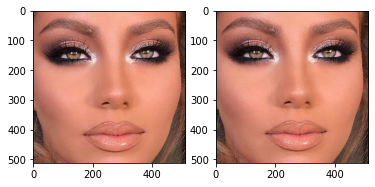

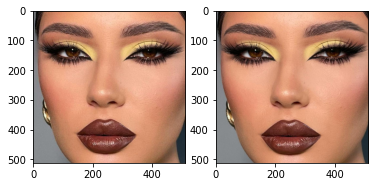

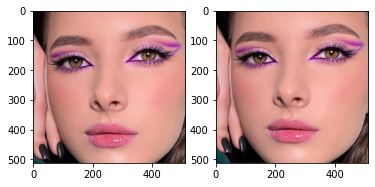

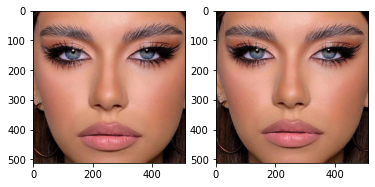

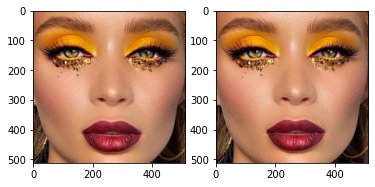

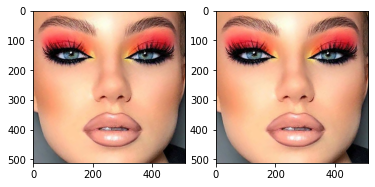

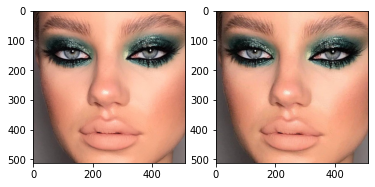

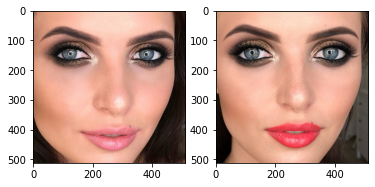

In [17]:
for path in graph.values():
    fig, axs = plt.subplots(1, len(path))
    for i, j in enumerate(path):
        axs[i].axis('off')
        axs[i].imshow(dataset[j].cpu().numpy().transpose(1, 2, 0))

In [18]:
to_delete = []

for root, nodes in graph.items():
    for node in nodes:
        if root != node:
            to_delete.append(dataset.imgs[node])
            
with open('to_delete.txt', 'w') as deletion_file:
    deletion_file.writelines('\n'.join(to_delete))

In [19]:
len(to_delete)

62

In [20]:
all_nodes = 0
for nodes in graph.values():
    all_nodes += len(nodes)
    
all_nodes

115

In [21]:
len(graph)

53

In [22]:
assert len(to_delete) == all_nodes - len(graph), 'Check deletion process, something went wrong'

In [23]:
!nvidia-smi

Mon Jan 31 14:48:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.129      Driver Version: 410.129      CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM3...  On   | 00000000:BC:00.0 Off |                    0 |
| N/A   31C    P0    67W / 350W |   2214MiB / 32480MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [24]:
for delete_file_name in to_delete:
    os.remove(images / delete_file_name)

In [25]:
len(os.listdir(images))

1458